# Análisis Exploratorio de Datos


## Introducción

El Análisis Exploratorio de Datos (EDA, Exploratory Data Analysis) es la primera etapa para comprender un conjunto de datos antes de entrenar modelos. Su propósito es describir los datos mediante estadística y visualización, detectar problemas de calidad (faltantes, anomalías, sesgos) y decidir qué preprocesamiento conviene aplicar.

En este proyecto trabajamos con imágenes microscópicas y sus anotaciones exportadas desde Label Studio. Cada imagen tiene un archivo de etiquetas asociado en formato .txt con coordenadas normalizadas (valores entre 0 y 1) que representan los objetos anotados de la clase Myotube. Por ello, el EDA no se limita a “columnas y filas”, sino que analiza tanto propiedades globales de las imágenes como características de las anotaciones.

## Objetivos

- Describir la estructura del dataset: organización de carpetas, formato de anotaciones y relación imagen–label.
- Identificar valores faltantes (imágenes sin etiquetas y etiquetas sin imágenes) y posibles patrones por carpeta.
- Obtener estadísticas descriptivas y visualizaciones de variables relevantes derivadas del dataset, por ejemplo:
  - dimensiones e intensidad global de las imágenes
  - cantidad de objetos por imagen
  - tamaños o áreas relativas de las anotaciones
- Detectar valores atípicos y errores comunes en anotaciones (archivos vacíos, coordenadas fuera de rango, objetos degenerados).
- Proponer y justificar operaciones de preprocesamiento necesarias para mejorar la calidad del dataset y su uso posterior en modelado (limpieza, normalización para visualización y criterios de control de calidad).

In [47]:
import cv2
import torch
import shutil
import hashlib
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
from PIL import Image

In [10]:
print("CUDA disponible:", torch.cuda.is_available())
print("GPU en uso:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No hay GPU")

CUDA disponible: True
GPU en uso: NVIDIA L4


## 1. Estructura de Datos

## Estructura de los datos

El conjunto de datos está organizado como un dataset de visión por computadora para segmentación/detección, compuesto por imágenes microscópicas y anotaciones generadas en Label Studio. La carpeta base contiene varias subcarpetas (IMG Emilio, IMG Isra, IMG Ivan, IMG Sam), además de un archivo comprimido con todas las imágenes.

Cada subcarpeta representa un subconjunto del dataset y mantiene la misma estructura interna.

Dentro de cada subcarpeta se encuentran cuatro elementos principales:

- images: directorio que contiene las imágenes en formato .png. Cada archivo corresponde a una muestra microscópica y su nombre incluye un identificador único y metadatos del origen o captura.
- labels: directorio que contiene un archivo .txt por cada imagen. El nombre del archivo de etiqueta coincide con el nombre base de la imagen, lo que permite establecer una correspondencia directa imagen–anotación.
- classes.txt: archivo que define las clases del problema. En este proyecto se utiliza una única clase: Myotube.
- notes.json: archivo de metadatos exportado por Label Studio que incluye información general del dataset (versión, año, contribuyente) y la definición de categorías, donde Myotube aparece como la clase con id 0.

Las anotaciones se almacenan en texto plano. Cada línea del archivo .txt representa un objeto anotado dentro de la imagen. El primer valor es el identificador de la clase (0) y el resto son pares de coordenadas (x, y) normalizadas en el rango [0, 1], que describen los vértices de un polígono asociado al objeto. Este formato permite reconstruir la región anotada.

Para facilitar el análisis exploratorio y evitar duplicación de lógica entre carpetas, se realizará una consolidación del dataset. En esta etapa se crearán dos carpetas unificadas:

- raw_all/images: contendrá todas las imágenes provenientes de las subcarpetas originales.
- raw_all/labels: contendrá todas las etiquetas correspondientes.

Además, se copiarán a raw_all los archivos classes.txt y notes.json como referencia global del conjunto. Esta condensación permitirá trabajar con una sola estructura homogénea durante el EDA, simplificando la validación de correspondencias imagen–label, el cálculo de estadísticas y la generación de visualizaciones.

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
base_path = Path("/content/drive/MyDrive/Myotubes/data/raw/")
out_path  = base_path.parent / "raw_all"

out_images = out_path / "images"
out_labels = out_path / "labels"

out_images.mkdir(parents=True, exist_ok=True)
out_labels.mkdir(parents=True, exist_ok=True)

In [22]:
img_dirs = sorted([d for d in base_path.iterdir()
                   if d.is_dir() and d.name.lower().startswith("img")])

print("Carpetas detectadas:")
for d in img_dirs:
    print(" -", d.name)

Carpetas detectadas:
 - IMG Emilio
 - IMG Isra
 - IMG Ivan
 - IMG Sam


In [23]:
first_dir = img_dirs[0]
classes_src = first_dir / "classes.txt"
notes_src   = first_dir / "notes.json"

IMAGE_EXTS = {".png"}
LABEL_EXTS = {".txt"}

if classes_src.exists():
    shutil.copy2(classes_src, out_path / "classes.txt")
    print(f"Copiado classes.txt desde: {first_dir.name}")
else:
    print(f"No se encontró classes.txt en: {first_dir}")

if notes_src.exists():
    shutil.copy2(notes_src, out_path / "notes.json")
    print(f"Copiado notes.json desde: {first_dir.name}")
else:
    print(f"No se encontró notes.json en: {first_dir}")

img_count = 0
lbl_count = 0
collisions = 0
skipped_images = 0
skipped_labels = 0

for d in img_dirs:
    tag = d.name.replace(" ", "_")
    src_images = d / "images"
    src_labels = d / "labels"

    # Images
    if src_images.exists():
        for p in src_images.iterdir():
            if not p.is_file():
                continue
            if p.suffix.lower() not in IMAGE_EXTS:
                skipped_images += 1
                continue
            dest = out_images / p.name
            if dest.exists():
                dest = out_images / f"{tag}__{p.name}"
                collisions += 1
            shutil.copy2(p, dest)
            img_count += 1
    else:
        print(f"No existe folder images en: {d}")

    # Labels (solo .txt)
    if src_labels.exists():
        for p in src_labels.iterdir():
            if not p.is_file():
                continue
            if p.suffix.lower() not in LABEL_EXTS:
                skipped_labels += 1
                continue
            dest = out_labels / p.name
            if dest.exists():
                dest = out_labels / f"{tag}__{p.name}"
                collisions += 1
            shutil.copy2(p, dest)
            lbl_count += 1
    else:
        print(f"No existe folder labels en: {d}")

print("\nConsolidación terminada")
print(f"Total imágenes copiadas: {img_count}")
print(f"Total labels copiados:  {lbl_count}")
print(f"Colisiones resueltas (renombre): {collisions}")
print(f"Archivos en imagen ignorados por extensión: {skipped_images}")
print(f"Archivos ignorados en labels por extensión (por ejemplo .gdoc): {skipped_labels}")

print("\nSalida:")
print(" -", out_path)
print(" -", out_images)
print(" -", out_labels)

Copiado classes.txt desde: IMG Emilio
Copiado notes.json desde: IMG Emilio

Consolidación terminada
Total imágenes copiadas: 306
Total labels copiados:  318
Colisiones resueltas (renombre): 0
Archivos de imagen ignorados por extensión: 0
Archivos ignorados en labels por extensión (por ejemplo .gdoc): 2

Salida:
 - /content/drive/MyDrive/Myotubes/data/raw_all
 - /content/drive/MyDrive/Myotubes/data/raw_all/images
 - /content/drive/MyDrive/Myotubes/data/raw_all/labels


In [24]:
base_path = Path("/content/drive/MyDrive/Myotubes/data/raw/")
out_path  = base_path.parent / "raw_all"

img_dir = out_path / "images"
lbl_dir = out_path / "labels"

# Indexar imágenes .png y labels .txt por "stem" (nombre sin extensión)
images = [p for p in img_dir.iterdir() if p.is_file() and p.suffix.lower() == ".png"]
labels = [p for p in lbl_dir.iterdir() if p.is_file() and p.suffix.lower() == ".txt"]

img_map = {p.stem: p for p in images}
lbl_map = {p.stem: p for p in labels}

img_stems = set(img_map.keys())
lbl_stems = set(lbl_map.keys())

imgs_without_lbl = sorted(img_stems - lbl_stems)
lbls_without_img = sorted(lbl_stems - img_stems)

print("Resumen de correspondencia")
print(f"Imágenes (.png) totales: {len(images)}")
print(f"Labels (.txt) totales:   {len(labels)}")
print(f"Imágenes sin label:      {len(imgs_without_lbl)}")
print(f"Labels sin imagen:       {len(lbls_without_img)}")

Resumen de correspondencia
Imágenes (.png) totales: 306
Labels (.txt) totales:   318
Imágenes sin label:      0
Labels sin imagen:       12


In [25]:
lbls_without_img

['1841443f-4b2b8615-75d4-4b2e-bccd-5731cc9b8ffc_A2_02_03_Best (1)',
 '2f239cb7-4b2b8615-75d4-4b2e-bccd-5731cc9b8ffc_A2_01_04_Best (1)',
 '30756772-35f892c1-da41-4a26-afbf-cb846cdf7436_A3_05_05_Best (1)',
 '5c9ac81f-6a55a585-2551-49dd-be42-a9371d0c40ea_A2_01_04_Best (1)',
 '69ee7dca-195893df-aa40-4944-8592-2fa62f94d608_B2_01_05_Best (1)',
 '80cc9caa-517e7812-564f-487a-9338-613f21c56c3a_A2_04_05_Best (1)',
 '8e7d9885-137a548c-ba26-40cc-bcac-d20d77cf6fd8_A2_03_04_Best (1)',
 '8fde6880-ca6c3fb1-be85-468c-9b60-7d9e94829e57_A1_04_04_Best (1)',
 '9f5cb165-195893df-aa40-4944-8592-2fa62f94d608_A3_04_06_Best (1)',
 'a5adf0fc-88797675-e851-4bb9-93df-0d446823b511_A3_05_05_Best (1)',
 'c89fec27-2ab5ac69-bc0f-4173-a326-cc1fecc40538_A2_04_05_Best (1)',
 'ef592a8c-eebfb204-b362-4bb2-8684-6dc0c6a18f99_A2_04_04_Best (1)']

Durante la validación de integridad tras la consolidación en raw_all, se identificaron 306 imágenes en formato .png y 318 archivos de etiquetas en formato .txt. La verificación de correspondencia por nombre base mostró que todas las imágenes cuentan con su archivo de etiquetas (0 imágenes sin label), pero existen 12 etiquetas sin imagen asociada.

Al inspeccionar los nombres de estas 12 etiquetas, se observó que todas incluyen el sufijo " (1)", lo cual sugiere que son copias generadas por el sistema de archivos (duplicados) y no anotaciones adicionales del dataset.


In [30]:
# Re-indexar labels desde el folder actual (ya sin duplicados)
labels = sorted([p for p in lbl_dir.iterdir() if p.is_file() and p.suffix.lower() == ".txt"])

# Variables para guardar casos
empty_label_names = []          # nombres de archivos .txt vacíos
missing_files = 0               # por si algún path desaparece
out_of_range_cases = []         # lista de dicts con detalles de líneas fuera de rango

# Labels vacíos (0 bytes o sin líneas útiles)
for p in labels:
    try:
        txt = p.read_text(encoding="utf-8", errors="ignore").strip()
    except FileNotFoundError:
        missing_files += 1
        continue

    if len(txt) == 0:
        empty_label_names.append(p.name)

print(f"Labels totales (.txt):    {len(labels)}")
print(f"Labels vacíos:            {len(empty_label_names)}")
print(f"Labels no encontrados:    {missing_files}")

# Chequeo de formato y rango de coordenadas (guardando casos)
bad_format = 0
total_lines = 0

for p in labels:
    try:
        txt = p.read_text(encoding="utf-8", errors="ignore").strip()
    except FileNotFoundError:
        continue

    if not txt:
        continue

    for line_idx, line in enumerate(txt.splitlines(), start=1):
        line = line.strip()
        if not line:
            continue

        total_lines += 1
        parts = line.split()

        # class_id + coords
        if len(parts) < 5:
            bad_format += 1
            continue

        # class id
        try:
            _cls = int(float(parts[0]))
        except Exception:
            bad_format += 1
            continue

        # coords float
        try:
            coords = list(map(float, parts[1:]))
        except Exception:
            bad_format += 1
            continue

        # pares (x,y)
        if len(coords) % 2 != 0:
            bad_format += 1
            continue

        # rango [0,1] (si falla, guardamos el caso)
        if any((c < 0.0 or c > 1.0) for c in coords):
            out_of_range_cases.append({
                "label_name": p.name,
                "line_number": line_idx,
                "line_text": line,
                "min_coord": min(coords),
                "max_coord": max(coords),
            })

out_of_range = len(out_of_range_cases)

print(f"Líneas totales revisadas:           {total_lines}")
print(f"Líneas con formato inválido:        {bad_format}")
print(f"Líneas con coordenadas fuera [0,1]: {out_of_range}")

# (Opcional) ver rápidamente los primeros ejemplos guardados
print("\nPrimeros 5 labels vacíos:")
print(empty_label_names[:5])

print("\nPrimeros 3 casos fuera de rango:")
for c in out_of_range_cases[:3]:
    print(c)


Labels totales (.txt):    306
Labels vacíos:            34
Labels no encontrados:    0
Líneas totales revisadas:           2148
Líneas con formato inválido:        0
Líneas con coordenadas fuera [0,1]: 30

Primeros 5 labels vacíos:
['002bbf6f-6a55a585-2551-49dd-be42-a9371d0c40ea_B3_02_06_Best.txt', '054d92e1-4bbba11f-35de-40fd-b133-6da58bccb122_B2_03_03_Best.txt', '0a5c134a-4bbba11f-35de-40fd-b133-6da58bccb122_A2_01_04_Best.txt', '0cb7e1ad-ca6c3fb1-be85-468c-9b60-7d9e94829e57_A2_02_05_Best.txt', '11a48a93-4bbba11f-35de-40fd-b133-6da58bccb122_B3_02_05_Best.txt']

Primeros 3 casos fuera de rango:
{'label_name': '0062917b-195893df-aa40-4944-8592-2fa62f94d608_B2_02_03_Best.txt', 'line_number': 22, 'line_text': '0 0.39640194864060796 0.03639107642207853 0.3857362213647736 0.032249046412045845 0.3927809159693466 -1.0965165675310187e-17 0.403446643245181 0.004142030010032673', 'min_coord': -1.0965165675310187e-17, 'max_coord': 0.403446643245181}
{'label_name': '10f23e6d-cell32.txt', 'line_num

In [29]:
# Re-indexar labels desde el folder actual (ya sin duplicados)
labels = sorted([p for p in lbl_dir.iterdir() if p.is_file() and p.suffix.lower() == ".txt"])

# Labels vacíos (0 bytes o sin líneas útiles)
empty_labels = []
missing_files = 0

for p in labels:
    try:
        txt = p.read_text(encoding="utf-8", errors="ignore").strip()
    except FileNotFoundError:
        missing_files += 1
        continue
    if len(txt) == 0:
        empty_labels.append(p.name)

print(f"Labels totales (.txt):    {len(labels)}")
print(f"Labels vacíos:            {len(empty_labels)}")
print(f"Labels no encontrados:    {missing_files}")

# Chequeo de formato y rango de coordenadas
bad_format = 0
out_of_range = 0
total_lines = 0

for p in labels:
    try:
        txt = p.read_text(encoding="utf-8", errors="ignore").strip()
    except FileNotFoundError:
        continue

    if not txt:
        continue

    for line in txt.splitlines():
        line = line.strip()
        if not line:
            continue

        total_lines += 1
        parts = line.split()

        # class_id + coords
        if len(parts) < 5:
            bad_format += 1
            continue

        # class id
        try:
            _cls = int(float(parts[0]))
        except Exception:
            bad_format += 1
            continue

        # coords float
        try:
            coords = list(map(float, parts[1:]))
        except Exception:
            bad_format += 1
            continue

        # pares (x,y)
        if len(coords) % 2 != 0:
            bad_format += 1
            continue

        # rango [0,1]
        if any((c < 0.0 or c > 1.0) for c in coords):
            out_of_range += 1

print(f"Líneas totales revisadas:           {total_lines}")
print(f"Líneas con formato inválido:        {bad_format}")
print(f"Líneas con coordenadas fuera [0,1]: {out_of_range}")

Labels totales (.txt):    306
Labels vacíos:            34
Labels no encontrados:    0
Líneas totales revisadas:           2148
Líneas con formato inválido:        0
Líneas con coordenadas fuera [0,1]: 30


Tras la consolidación y limpieza de duplicados, el conjunto final quedó compuesto por 306 archivos de etiquetas en formato .txt. Al evaluar su contenido, se identificaron 34 etiquetas vacías, es decir, archivos sin líneas útiles de anotación. Esto sugiere que existen imágenes sin objetos anotados.

En términos de calidad de formato, se revisaron 2,148 líneas de anotaciones en total y no se encontraron errores de estructura (0 líneas con formato inválido).

Sin embargo, se detectaron 30 líneas con coordenadas fuera del rango [0, 1], lo cual indica anotaciones potencialmente inconsistentes o errores de normalización.


A continuación se analiza la cantidad de etiquetas por imagen. Para cada archivo .txt se contabiliza el número de objetos anotados, considerando cada línea no vacía como una instancia. Con esta variable se genera una visualización de la distribución de etiquetas por imagen, lo que permite identificar imágenes sin anotaciones, así como posibles valores atípicos con un número inusualmente alto de etiquetas.

In [32]:
def count_objects_in_label(label_path):
    """Cuenta objetos como número de líneas no vacías dentro del .txt."""
    txt = label_path.read_text(encoding="utf-8", errors="ignore").strip()
    if not txt:
        return 0
    return sum(1 for line in txt.splitlines() if line.strip())

rows = []
for img in images:
    stem = img.stem
    label_path = lbl_map.get(stem, None)
    n = count_objects_in_label(label_path) if label_path else 0
    rows.append({"image_name": img.name, "n_labels": n})

df_counts = pd.DataFrame(rows)

In [38]:
df_counts.head()

,image_name,n_labels
0,11a48a93-4bbba11f-35de-40fd-b133-6da58bccb122_...,0
1,0062917b-195893df-aa40-4944-8592-2fa62f94d608_...,22
2,0908fca7-363cffdd-c74f-4c96-98c0-e8734e461b69_...,10
3,14e33cfd-88797675-e851-4bb9-93df-0d446823b511_...,10
4,07722ad5-42d5b90b-a80c-4524-b17f-99018fff2a56_...,1


In [34]:
# Estadísticas rápidas
print("Resumen n_labels por imagen")
print(df_counts["n_labels"].describe())

Resumen n_labels por imagen
count    306.000000
mean       7.019608
std        5.954990
min        0.000000
25%        3.000000
50%        6.000000
75%       10.000000
max       34.000000
Name: n_labels, dtype: float64


Con la distribución de etiquetas por imagen se observa una variabilidad considerable en el número de objetos anotados. En las 306 imágenes, el promedio es de 7.02 etiquetas por imagen con una desviación estándar de 5.95, lo que indica alta dispersión.

También se identifican casos extremos. Existen imágenes sin anotaciones (mínimo = 0) y un conjunto pequeño con conteos muy altos (máximo = 34), lo cual sugiere una distribución sesgada hacia la derecha.

A partir del dataframe por objeto se obtuvieron métricas geométricas de cada anotación, incluyendo ángulo de orientación, ancho, alto y área (en escala normalizada y en pixeles).

In [42]:
# 1) Parseo simple: línea -> puntos (x,y)
def line_to_points(line):
    parts = line.strip().split()
    if len(parts) < 5:
        return None
    try:
        coords = np.array(list(map(float, parts[1:])), dtype=float)
    except Exception:
        return None
    if coords.size % 2 != 0:
        return None
    coords = np.clip(coords, 0.0, 1.0)  # tolerancia numérica
    xs = coords[0::2]
    ys = coords[1::2]
    return np.stack([xs, ys], axis=1)

# 2) Rectángulo mínimo rotado
def min_rot_rect(points):
    best = None  # (area, w, h, angle)
    n = len(points)
    if n < 2:
        return None

    for i in range(n):
        p0 = points[i]
        p1 = points[(i + 1) % n]
        edge = p1 - p0
        angle = np.arctan2(edge[1], edge[0])

        c, s = np.cos(-angle), np.sin(-angle)
        R = np.array([[c, -s],
                      [s,  c]])

        rot = points @ R.T
        min_xy = rot.min(axis=0)
        max_xy = rot.max(axis=0)
        w = max_xy[0] - min_xy[0]
        h = max_xy[1] - min_xy[1]
        area = w * h

        if (best is None) or (area < best[0]):
            best = (area, w, h, angle)

    area, w, h, angle = best
    # normalizar para que w >= h por consistencia
    if h > w:
        w, h = h, w
        angle = angle + np.pi / 2

    return float(angle), float(w), float(h), float(area)

rows = []

for lbl_path in labels:
    stem = lbl_path.stem
    img_path = img_map.get(stem, None)
    if img_path is None:
        continue

    w_img, h_img = Image.open(img_path).size

    txt = lbl_path.read_text(encoding="utf-8", errors="ignore").strip()
    if not txt:
        continue

    box_idx = 0
    for line in txt.splitlines():
        line = line.strip()
        if not line:
            continue

        pts = line_to_points(line)
        if pts is None:
            continue

        res = min_rot_rect(pts)
        if res is None:
            continue

        angle, w_norm, h_norm, area_norm = res

        rows.append({
            "image_name": img_path.name,
            "label_name": lbl_path.name,
            "box_id": box_idx,
            "points_norm": pts.tolist(),      # lista de puntos [[x,y],...]
            "angle_rad": angle,
            "width_norm": w_norm,
            "height_norm": h_norm,
            "area_norm": area_norm,
            "width_px": w_norm * w_img,
            "height_px": h_norm * h_img,
            "area_px": (w_norm * w_img) * (h_norm * h_img),
        })
        box_idx += 1

df_boxes = pd.DataFrame(rows)
df_boxes.head()

,image_name,label_name,box_id,points_norm,angle_rad,width_norm,height_norm,area_norm,width_px,height_px,area_px
0,00538475-f23e64e2-8f62-4391-bd64-e8ecbaafc9be_...,00538475-f23e64e2-8f62-4391-bd64-e8ecbaafc9be_...,0,"[[0.5905506139079177, 0.33316588313765144], [0...",2.713316,0.091054,0.023505,0.002140,236.010859,45.692960,10784.034701
1,00538475-f23e64e2-8f62-4391-bd64-e8ecbaafc9be_...,00538475-f23e64e2-8f62-4391-bd64-e8ecbaafc9be_...,1,"[[0.4567050247714986, 0.3876307923356174], [0....",-0.428276,0.169882,0.030802,0.005233,440.335165,59.879885,26367.218918
2,0062917b-195893df-aa40-4944-8592-2fa62f94d608_...,0062917b-195893df-aa40-4944-8592-2fa62f94d608_...,0,"[[0.47654503794159964, 0.19275395250663194], [...",-1.680115,0.055812,0.010397,0.000580,144.664843,20.212164,2923.989591
3,0062917b-195893df-aa40-4944-8592-2fa62f94d608_...,0062917b-195893df-aa40-4944-8592-2fa62f94d608_...,1,"[[0.42445818235071214, 0.20518084040207896], [...",1.329231,0.046029,0.012213,0.000562,119.307258,23.741156,2832.492228
4,0062917b-195893df-aa40-4944-8592-2fa62f94d608_...,0062917b-195893df-aa40-4944-8592-2fa62f94d608_...,2,"[[0.3732855181786822, 0.5532119253296526], [0....",0.823309,0.032860,0.007146,0.000235,85.173054,13.891720,1183.200225


In [43]:
df_boxes.describe()

,box_id,angle_rad,width_norm,height_norm,area_norm,width_px,height_px,area_px
count,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2.148000e+03
mean,5.527467,0.214227,0.080389,0.020699,0.002613,208.368953,40.238545,1.316630e+04
std,5.374099,1.654983,0.064801,0.025304,0.019878,167.964474,49.191741,1.001604e+05
min,0.000000,-3.114841,0.001411,0.000752,0.000001,3.656543,1.462617,5.348121e+00
25%,2.000000,-1.196375,0.045876,0.012395,0.000631,118.909750,24.095467,3.181278e+03
50%,4.000000,0.518717,0.062853,0.018009,0.001125,162.913921,35.010019,5.669137e+03
75%,8.000000,1.570796,0.095070,0.025130,0.002136,246.421691,48.852861,1.076077e+04
max,33.000000,4.712389,0.955224,0.761194,0.727111,2475.940299,1479.761194,3.663800e+06


Los resultados muestran una alta variabilidad en el tamaño de las cajas: la mayoría de los objetos tiene dimensiones pequeñas relativas a la imagen, pero existen casos extremos con cajas muy grandes que cubren una porción considerable del campo visual.

## Análisis univariante

El análisis univariante describe el comportamiento de cada variable por separado. En esta etapa se utilizan visualizaciones como histogramas y boxplots para identificar la forma de las distribuciones, el nivel de dispersión, posibles asimetrías (sesgo) y la presencia de valores atípicos.

En este proyecto se realiza el análisis en dos niveles: a nivel imagen (conteo de anotaciones) y a nivel objeto (medidas geométricas derivadas de las anotaciones).

## Cantidad de Etiquetas por Imagen

A continuación se explora df_counts, que contiene el número de etiquetas (objetos anotados) por imagen. Esta variable permite evaluar cuántas instancias aparecen típicamente por imagen e identificar casos con cero anotaciones o con conteos inusualmente altos.


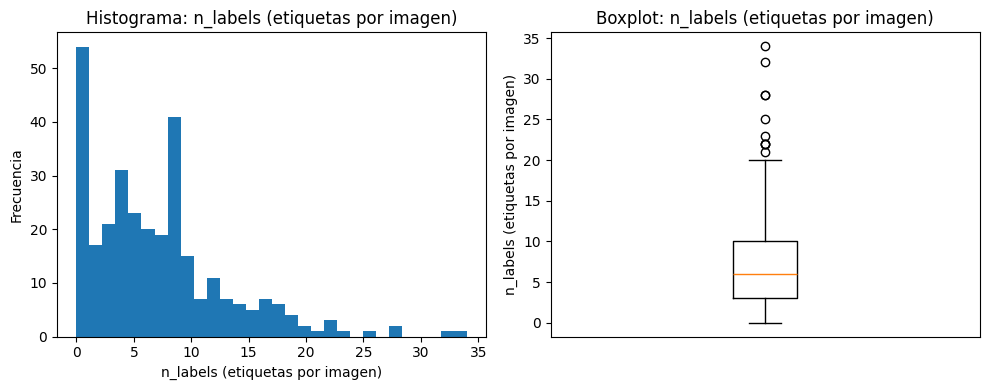

In [44]:
def hist_box(series, title, bins=30):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    axes[0].hist(series.dropna(), bins=bins)
    axes[0].set_title(f"Histograma: {title}")
    axes[0].set_xlabel(title)
    axes[0].set_ylabel("Frecuencia")

    axes[1].boxplot(series.dropna(), vert=True)
    axes[1].set_title(f"Boxplot: {title}")
    axes[1].set_ylabel(title)
    axes[1].set_xticks([])

    plt.tight_layout()
    plt.show()

# df_counts: frecuencia de etiquetas por imagen
hist_box(df_counts["n_labels"], "n_labels (etiquetas por imagen)", bins=30)

# Características de las Etiquetas

A continuación se exploran las variables numéricas de df_boxes, que contiene mediciones geométricas por objeto anotado, como ángulo, ancho, alto y área (en escala normalizada y en pixeles). Para cada variable se presenta un histograma y su boxplot correspondiente, con el fin de caracterizar su distribución e identificar posibles valores atípicos.


Columnas numéricas en df_boxes:
['box_id', 'angle_rad', 'width_norm', 'height_norm', 'area_norm', 'width_px', 'height_px', 'area_px']


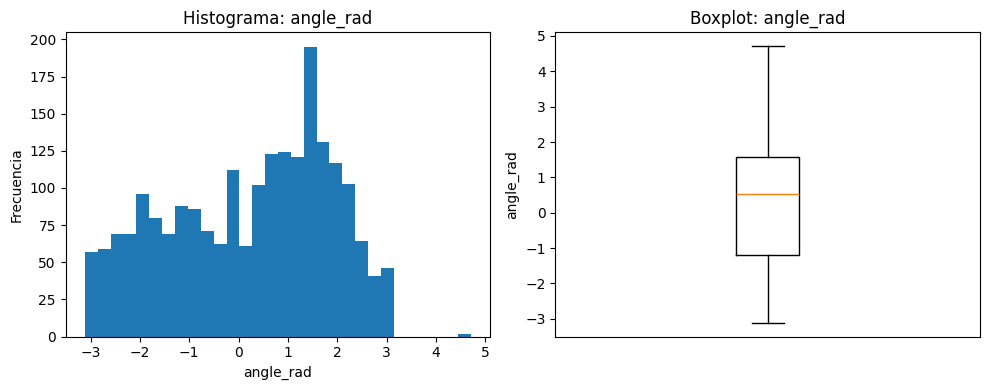

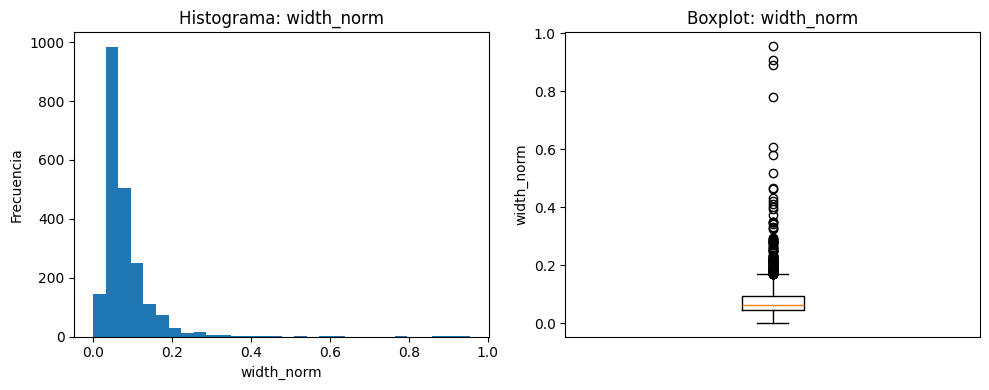

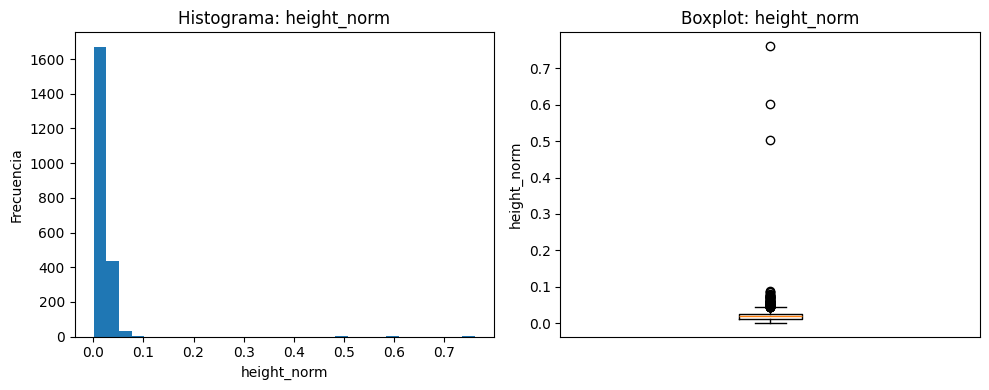

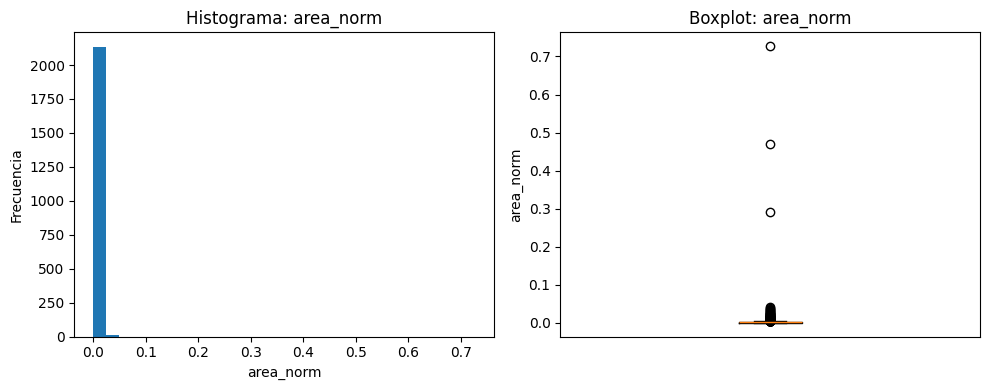

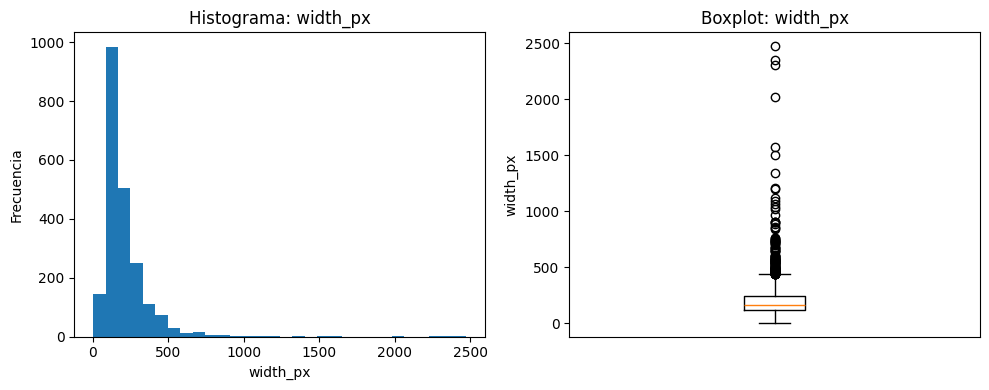

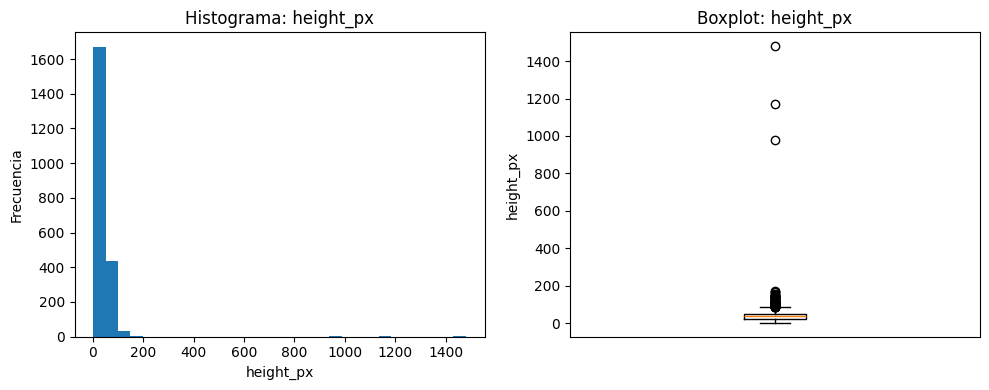

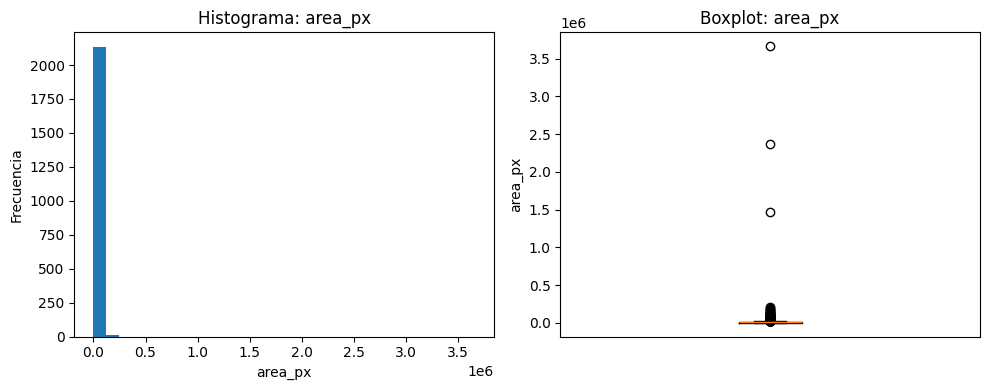

In [46]:
# df_boxes: histogramas + boxplots para todas las variables numéricas
num_cols = df_boxes.select_dtypes(include="number").columns.tolist()

print("Columnas numéricas en df_boxes:")
print(num_cols)

for col in num_cols[1:]:
    hist_box(df_boxes[col], col, bins=30)

Las visualizaciones univariantes muestran que el número de etiquetas por imagen presenta una distribución asimétrica a la derecha: la mayor parte de las imágenes contiene pocos objetos anotados, mientras que existe una cola de imágenes con conteos altos que aparecen como outliers en el boxplot. Esto sugiere variabilidad importante en la densidad de estructuras por muestra y la conveniencia de considerar estrategias para mitigar el efecto de casos extremos durante el entrenamiento.

En df_boxes, las distribuciones de ancho, alto y área en escala normalizada también son claramente sesgadas hacia valores pequeños. La mayoría de las cajas corresponde a objetos relativamente pequeños dentro de la imagen, pero se observan outliers con dimensiones y áreas considerablemente mayores, lo cual podría deberse a anotaciones que cubren regiones extensas o a inconsistencias en el etiquetado.

El ángulo presenta dispersión amplia, consistente con la presencia de estructuras orientadas en múltiples direcciones.

In [ ]:
def image_metrics_cv2(img_path: Path):
    img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
    if img is None:
        return None

    h, w = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Intensidad
    mean_int = float(gray.mean())
    std_int  = float(gray.std())

    # Percentiles y rango dinámico (robusto)
    p01, p50, p99 = np.percentile(gray, [1, 50, 99]).astype(float)
    dyn_range = float(p99 - p01)

    # Enfoque (varianza del Laplaciano)
    lap_var = float(cv2.Laplacian(gray, cv2.CV_64F).var())

    # Densidad de bordes (Canny)
    edges = cv2.Canny(gray, 50, 150)
    edge_density = float((edges > 0).mean())

    # Entropía del histograma
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256]).ravel()
    hist = hist / (hist.sum() + 1e-12)
    entropy = float(-(hist * np.log2(hist + 1e-12)).sum())

    return {
        "image_name": img_path.name,
        "width": int(w),
        "height": int(h),
        "aspect_ratio": float(w / h) if h != 0 else np.nan,
        "mean_intensity": mean_int,
        "std_intensity": std_int,
        "p01": float(p01),
        "p50": float(p50),
        "p99": float(p99),
        "dynamic_range_p99_p01": dyn_range,
        "sharpness_laplacian": lap_var,
        "edge_density": edge_density,
        "entropy": entropy,
    }

In [49]:
rows = []
failed = 0
for p in images:
    m = image_metrics_cv2(p)
    if m is None:
        failed += 1
        continue
    rows.append(m)

df_images = pd.DataFrame(rows)

print("Imágenes procesadas:", len(df_images))
print("Fallos de lectura:", failed)

Imágenes procesadas: 306
Fallos de lectura: 0


In [50]:
df_images.head()

,image_name,width,height,aspect_ratio,mean_intensity,std_intensity,p01,p50,p99,dynamic_range_p99_p01,sharpness_laplacian,edge_density,entropy
0,11a48a93-4bbba11f-35de-40fd-b133-6da58bccb122_...,2592,1944,1.333333,157.356656,31.927776,70.0,157.0,229.0,159.0,7276.984787,0.398298,7.017889
1,0062917b-195893df-aa40-4944-8592-2fa62f94d608_...,2592,1944,1.333333,155.762809,32.232937,65.0,156.0,226.0,161.0,7067.577654,0.391727,7.035964
2,0908fca7-363cffdd-c74f-4c96-98c0-e8734e461b69_...,2592,1944,1.333333,144.681882,34.647741,65.0,143.0,227.0,162.0,7497.168311,0.391876,7.153018
3,14e33cfd-88797675-e851-4bb9-93df-0d446823b511_...,2592,1944,1.333333,153.112652,31.422973,65.0,153.0,224.0,159.0,6948.585642,0.390940,7.000628
4,07722ad5-42d5b90b-a80c-4524-b17f-99018fff2a56_...,2592,1944,1.333333,154.522714,36.786160,61.0,154.0,236.0,175.0,9177.337040,0.386223,7.234298


### Caracterización de imágenes

En esta sección calcularemos métricas para caracterizar las imágenes microscópicas desde el punto de vista de intensidad, contraste y estructura. En particular, se estiman estadísticas de brillo (media y desviación estándar de intensidad), un rango dinámico robusto basado en percentiles (p99 − p01), una medida de nitidez a partir de la varianza del Laplaciano, la densidad de bordes mediante Canny y una aproximación a la complejidad visual a través de la entropía del histograma.

Estas métricas permiten identificar variabilidad entre capturas, detectar posibles outliers (imágenes muy oscuras, poco contrastadas o desenfocadas) y aportar evidencia para justificar decisiones de preprocesamiento.

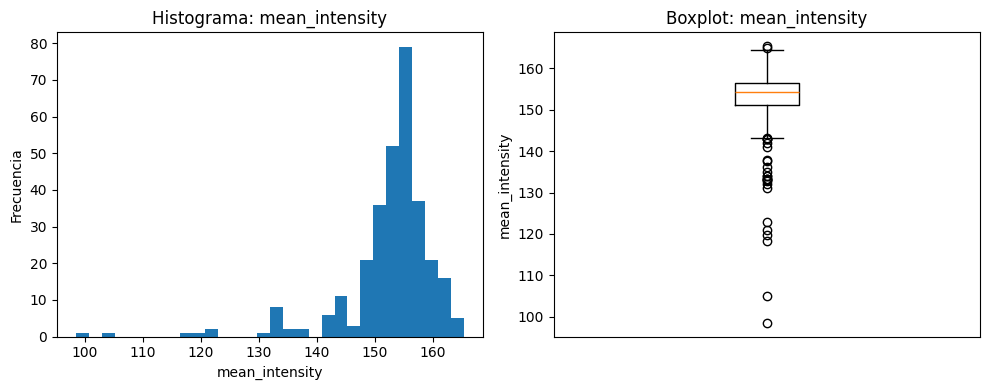

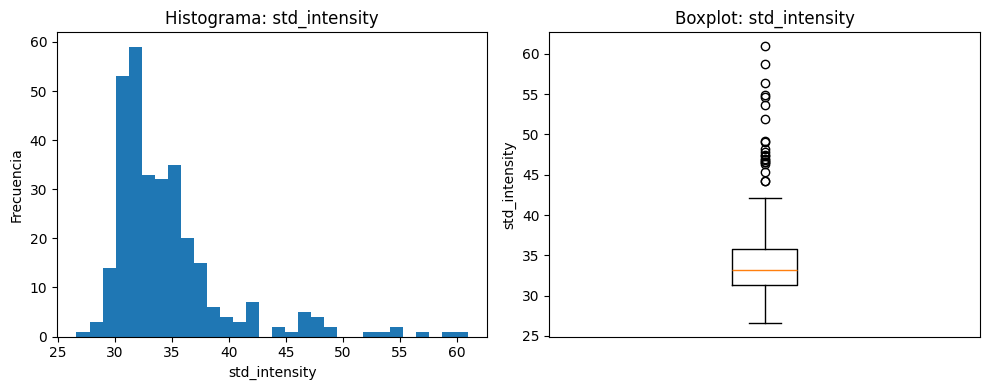

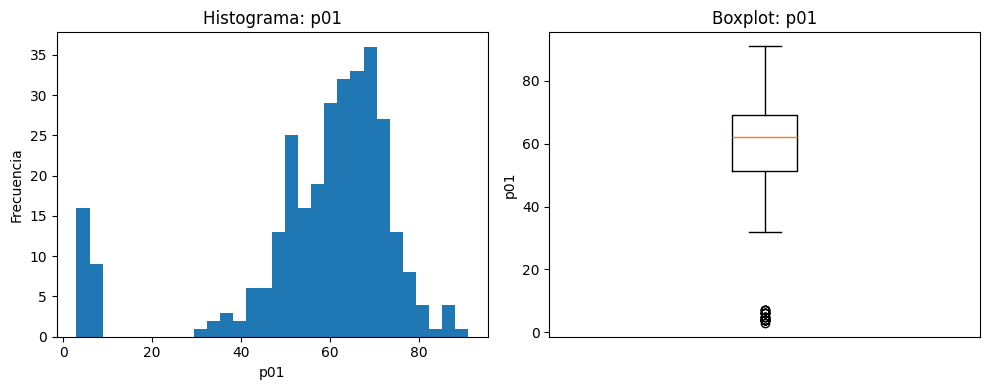

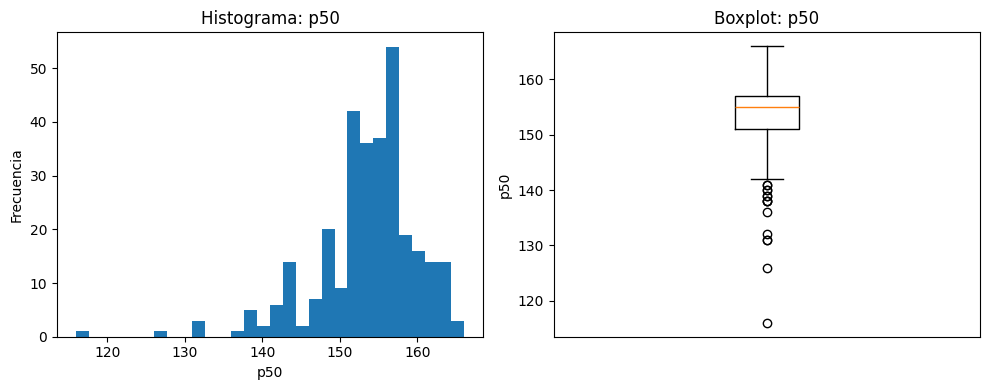

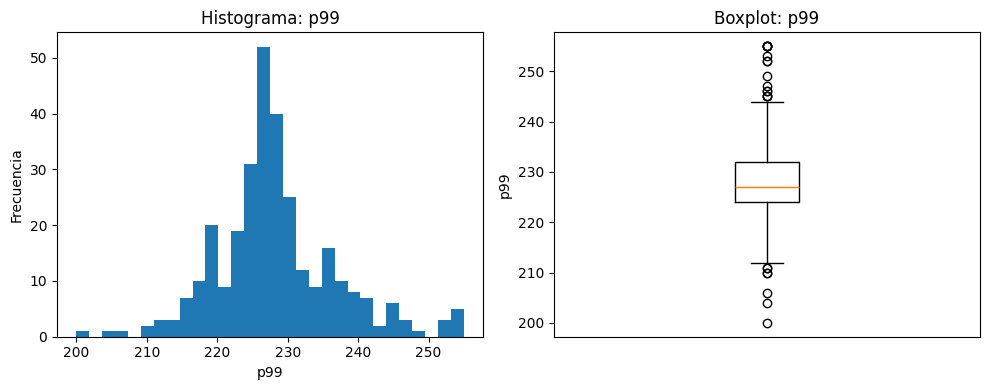

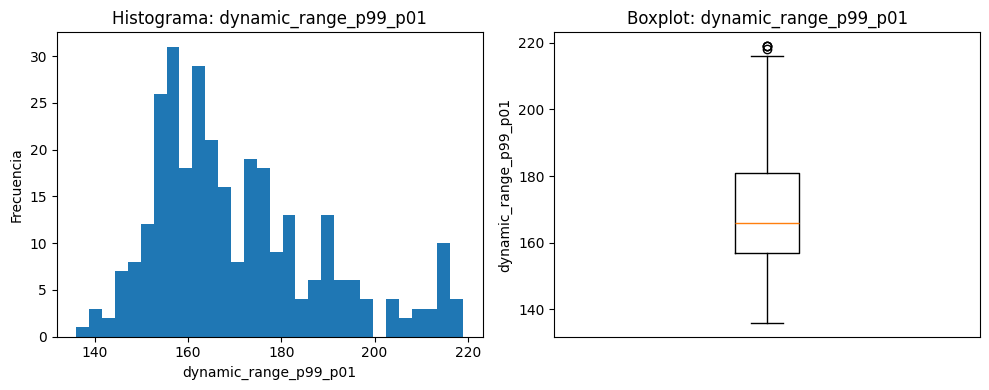

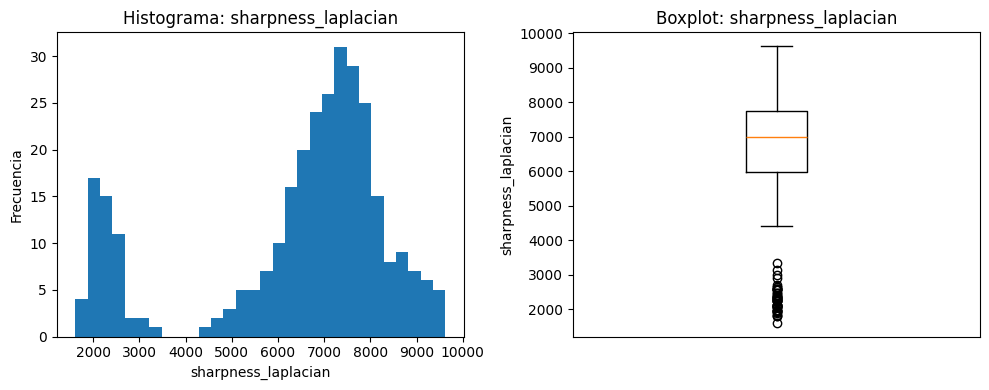

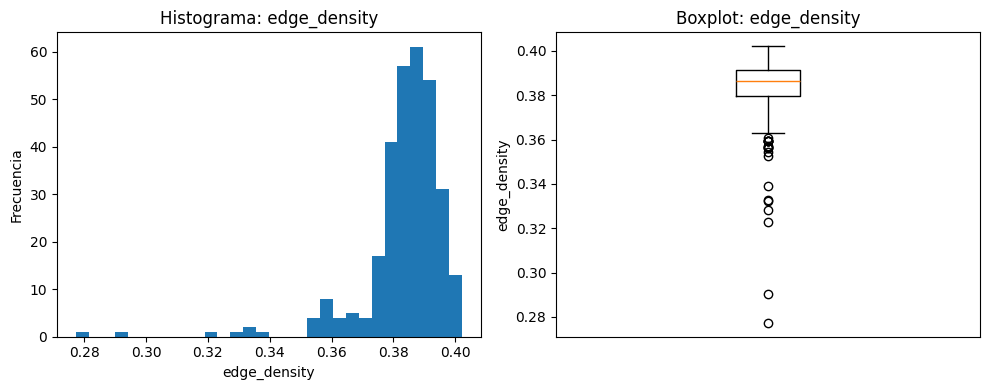

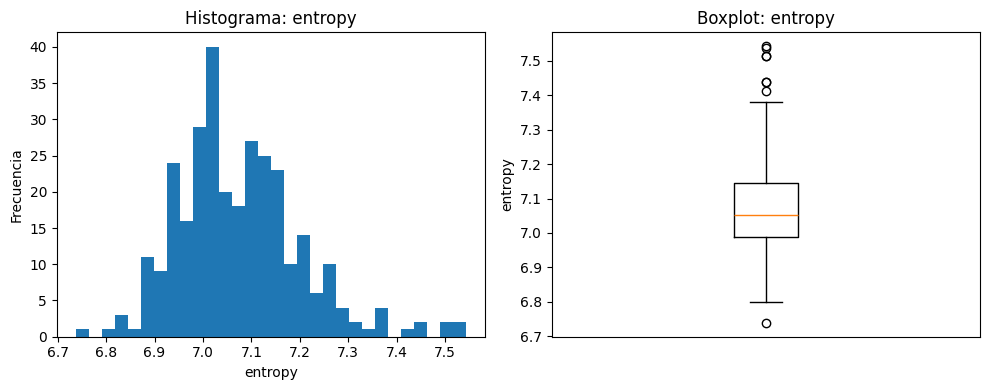

In [51]:
num_cols = df_images.select_dtypes(include="number").columns.tolist()
for col in num_cols[3:]:
    hist_box(df_images[col], col, bins=30)

Las distribuciones de mean_intensity y std_intensity indican que la mayoría de las imágenes presentan niveles de iluminación y variabilidad de intensidad relativamente consistentes, con un conjunto pequeño de outliers hacia valores más bajos de brillo y/o menor contraste. Esto sugiere que, aunque el dataset es bastante homogéneo en iluminación, existen algunas capturas atípicas que podrían beneficiarse de normalización o ajuste de contraste para mantener una apariencia comparable.

El rango dinámico robusto (p99 − p01) muestra dispersión moderada y presencia de casos con rango dinámico alto, lo que apunta a variabilidad en contraste global entre imágenes.

La métrica de sharpness_laplacian presenta dos comportamientos: una concentración principal en valores altos (imágenes relativamente nítidas) y un grupo menor con valores mucho más bajos, que aparece como outliers. Estos casos son candidatos a revisión, ya que pueden corresponder a imágenes desenfocadas o con bajo contenido de alta frecuencia, lo cual puede afectar tanto la anotación como el desempeño del modelo.

La edge_density se concentra en un intervalo estrecho, con algunos outliers hacia valores más bajos.

Finalmente, la entropía se agrupa alrededor de un valor central con poca variación, lo que indica una complejidad visual relativamente uniforme entre la mayoría de las capturas.

En conjunto, estas métricas sugieren un dataset mayormente consistente, con un subconjunto reducido de imágenes atípicas en brillo, contraste o nitidez. Esto justifica considerar un preprocesamiento ligero (por ejemplo, normalización por percentiles y verificación de imágenes con baja nitidez) antes del modelado.


## 3. Análisis Multivariado

El análisis bi/multivariante busca explorar relaciones entre dos o más variables para identificar patrones, dependencias y posibles factores que influyen en la distribución del conjunto de datos. En este proyecto, el análisis se aborda en dos niveles: a nivel imagen, relacionando métricas visuales con la cantidad de anotaciones, y a nivel objeto, analizando la geometría de las cajas rotadas para entender variaciones en tamaño, forma y orientación. Estos resultados permiten proponer decisiones de preprocesamiento y control de calidad antes del modelado.


### 1) Integración

En esta sección se integra la información de df_images y df_counts para construir una tabla única por imagen. El objetivo es contar con métricas visuales (brillo, contraste, nitidez y estructura) junto con el número de objetos anotados, lo cual permite analizar de forma consistente cómo las características de la imagen se relacionan con la densidad de anotaciones.



In [52]:
df_img_counts = df_images.merge(df_counts, on="image_name", how="left")

# Asegurar que n_labels exista y no tenga NaN (por si acaso)
df_img_counts["n_labels"] = df_img_counts["n_labels"].fillna(0)

print("Filas en df_img_counts:", len(df_img_counts))
display(df_img_counts.head())

Filas en df_img_counts: 306


,image_name,width,height,aspect_ratio,mean_intensity,std_intensity,p01,p50,p99,dynamic_range_p99_p01,sharpness_laplacian,edge_density,entropy,n_labels
0,11a48a93-4bbba11f-35de-40fd-b133-6da58bccb122_...,2592,1944,1.333333,157.356656,31.927776,70.0,157.0,229.0,159.0,7276.984787,0.398298,7.017889,0
1,0062917b-195893df-aa40-4944-8592-2fa62f94d608_...,2592,1944,1.333333,155.762809,32.232937,65.0,156.0,226.0,161.0,7067.577654,0.391727,7.035964,22
2,0908fca7-363cffdd-c74f-4c96-98c0-e8734e461b69_...,2592,1944,1.333333,144.681882,34.647741,65.0,143.0,227.0,162.0,7497.168311,0.391876,7.153018,10
3,14e33cfd-88797675-e851-4bb9-93df-0d446823b511_...,2592,1944,1.333333,153.112652,31.422973,65.0,153.0,224.0,159.0,6948.585642,0.390940,7.000628,10
4,07722ad5-42d5b90b-a80c-4524-b17f-99018fff2a56_...,2592,1944,1.333333,154.522714,36.786160,61.0,154.0,236.0,175.0,9177.337040,0.386223,7.234298,1


Se logró integrar métricas visuales por imagen con el conteo de etiquetas, lo que permite analizar si condiciones de captura (brillo, contraste, nitidez) se asocian con la densidad de anotaciones.

### 2) Relación entre métricas de imagen y número de etiquetas

En esta sección se exploran relaciones bivariadas entre las métricas de caracterización de imagen y el número de etiquetas por imagen. Se evalúa si variables como brillo medio, rango dinámico, nitidez, densidad de bordes y entropía presentan asociaciones con la cantidad de objetos anotados. Esto ayuda a identificar si la calidad o condiciones de captura pueden influir en la anotación y en el desempeño esperado del modelo.

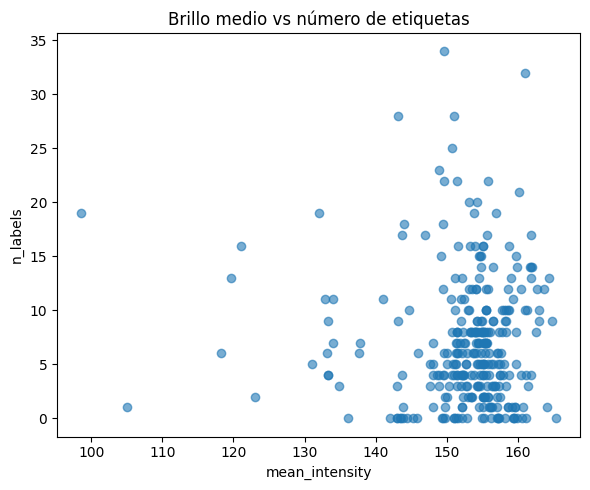

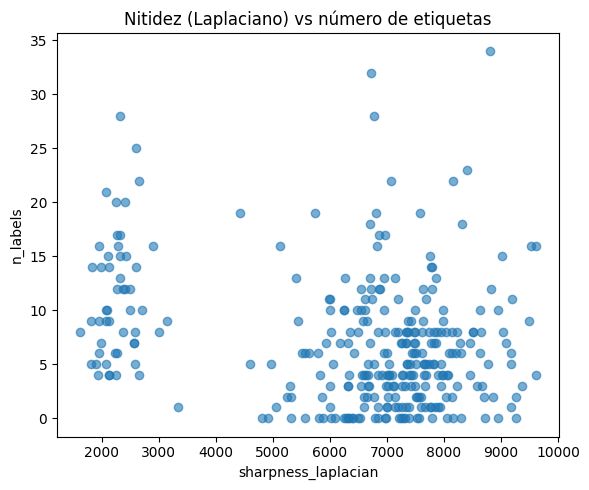

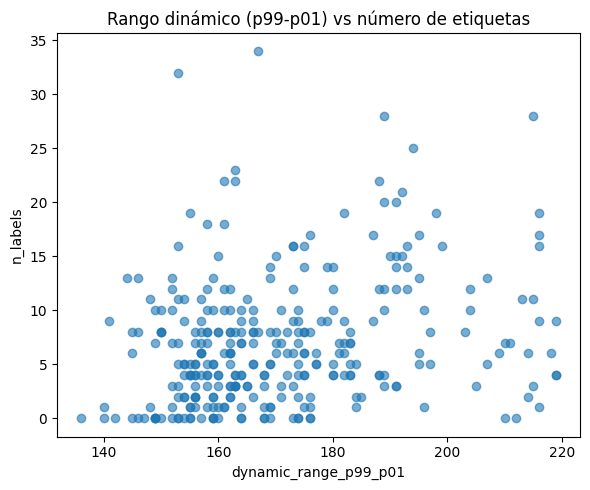

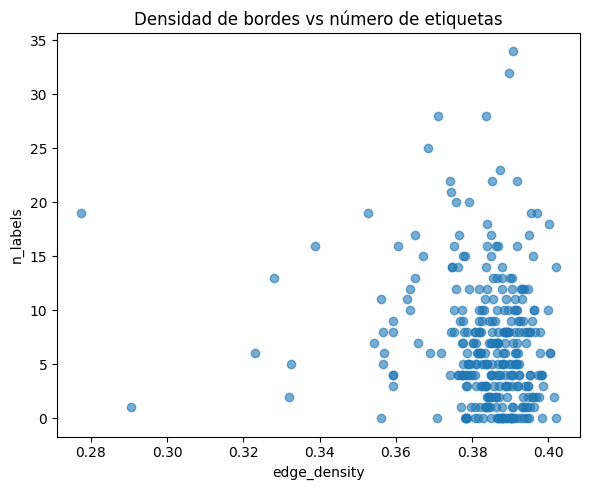

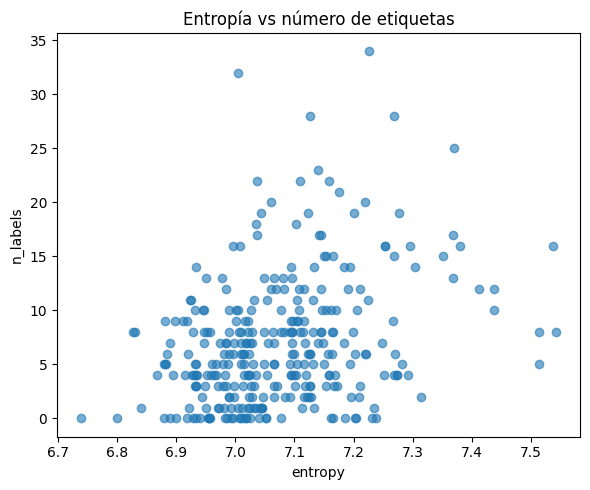

In [53]:
pairs_img = [
    ("mean_intensity", "n_labels", "Brillo medio vs número de etiquetas"),
    ("sharpness_laplacian", "n_labels", "Nitidez (Laplaciano) vs número de etiquetas"),
    ("dynamic_range_p99_p01", "n_labels", "Rango dinámico (p99-p01) vs número de etiquetas"),
    ("edge_density", "n_labels", "Densidad de bordes vs número de etiquetas"),
    ("entropy", "n_labels", "Entropía vs número de etiquetas"),
]

for x, y, title in pairs_img:
    plt.figure(figsize=(6, 5))
    plt.scatter(df_img_counts[x], df_img_counts[y], alpha=0.6)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.tight_layout()
    plt.show()

A continuación se describen algunos hallazgos:
* Brillo vs etiquetas: no se aprecia una relación lineal clara, la mayoría de imágenes se concentra en un rango de brillo similar, pero con conteos muy variables.
* Nitidez vs etiquetas: se observan grupos de nitidez (valores bajos y altos), pero el número de etiquetas sigue siendo disperso, la nitidez por sí sola no explica el conteo.
* Entropía vs etiquetas: la entropía varía en un rango relativamente estrecho y no muestra una tendencia marcada con n_labels, su efecto parece débil frente a otros factores.

### 3) Correlación multivariante a nivel imagen

En esta sección se calcula una matriz de correlación entre múltiples variables numéricas a nivel imagen, incluyendo el número de etiquetas y métricas de intensidad, contraste, nitidez y estructura. El propósito es obtener una vista global de dependencias lineales, detectar variables redundantes y seleccionar métricas relevantes para análisis posteriores o para justificar estrategias de preprocesamiento.


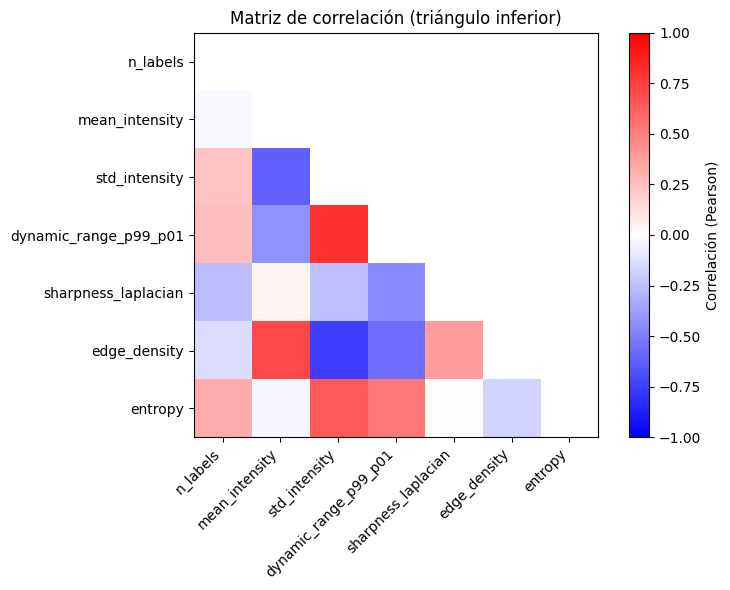

In [59]:
corr_cols = [
    "n_labels",
    "mean_intensity",
    "std_intensity",
    "dynamic_range_p99_p01",
    "sharpness_laplacian",
    "edge_density",
    "entropy",
]

corr_df = df_img_counts[corr_cols].corr(numeric_only=True)

mask_upper = np.triu(np.ones_like(corr_df, dtype=bool))  # True en diagonal+superior
corr_lower = corr_df.mask(mask_upper)

plt.figure(figsize=(8, 6))
plt.imshow(corr_lower.values, vmin=-1, vmax=1, cmap="bwr")  # azul->rojo, escala fija [-1,1]
plt.colorbar(label="Correlación (Pearson)")

plt.xticks(range(len(corr_cols)), corr_cols, rotation=45, ha="right")
plt.yticks(range(len(corr_cols)), corr_cols)

plt.title("Matriz de correlación (triángulo inferior)")
plt.tight_layout()
plt.show()

Las correlaciones más fuertes aparecen entre métricas relacionadas entre sí (por ejemplo, contraste y rango dinámico), mientras que n_labels tiende a mostrar asociaciones bajas con las métricas globales de imagen. Esto sugiere que el número de anotaciones depende más del contenido biológico y la densidad de estructuras que de una sola métrica global de calidad.

### 4) Relación entre variables geométricas a nivel objeto

En esta sección se analizan relaciones bivariadas entre variables geométricas derivadas de las anotaciones a nivel objeto. Se explora la relación entre ancho y alto de las cajas rotadas, así como asociaciones entre área y ángulo, y entre aspect ratio y área. Esto permite caracterizar la variabilidad de tamaño, forma y orientación de las estructuras anotadas, e identificar posibles outliers o patrones consistentes con la morfología esperada.


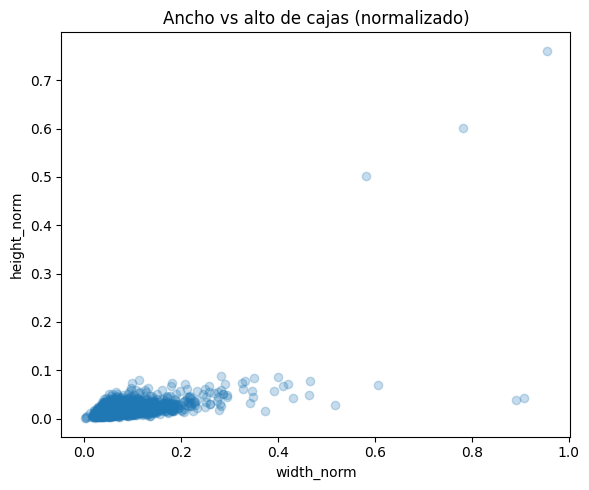

In [55]:
plt.figure(figsize=(6, 5))
plt.scatter(df_boxes["width_norm"], df_boxes["height_norm"], alpha=0.25)
plt.xlabel("width_norm")
plt.ylabel("height_norm")
plt.title("Ancho vs alto de cajas (normalizado)")
plt.tight_layout()
plt.show()

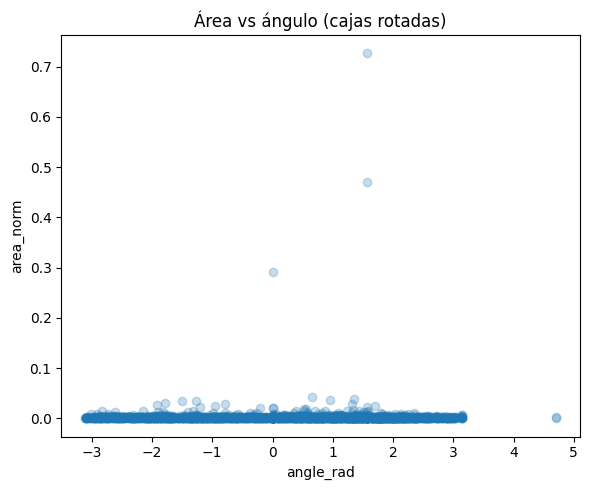

In [56]:
plt.figure(figsize=(6, 5))
plt.scatter(df_boxes["angle_rad"], df_boxes["area_norm"], alpha=0.25)
plt.xlabel("angle_rad")
plt.ylabel("area_norm")
plt.title("Área vs ángulo (cajas rotadas)")
plt.tight_layout()
plt.show()

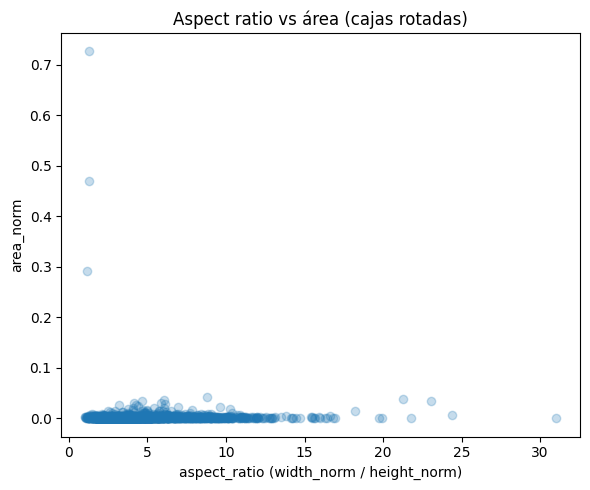

In [57]:
eps = 1e-12
aspect_ratio = df_boxes["width_norm"] / (df_boxes["height_norm"] + eps)

plt.figure(figsize=(6, 5))
plt.scatter(aspect_ratio, df_boxes["area_norm"], alpha=0.25)
plt.xlabel("aspect_ratio (width_norm / height_norm)")
plt.ylabel("area_norm")
plt.title("Aspect ratio vs área (cajas rotadas)")
plt.tight_layout()
plt.show()

El análisis bi/multivariante presentado no corresponde a un escenario clásico de predicción tabular, donde existe una variable objetivo numérica o categórica y se busca modelarla directamente a partir de variables independientes. En este proyecto el objetivo principal es visión por computadora (detección/segmentación de estructuras en imágenes), por lo que las relaciones entre métricas globales de imagen, conteos de anotaciones y variables geométricas no implican causalidad ni se interpretan como un modelo predictivo formal.

Aun así, este análisis es útil como guía exploratoria: permite identificar patrones de consistencia o variabilidad en la adquisición (brillo, contraste, nitidez), detectar posibles outliers y validar supuestos sobre el conjunto de datos.

## 4. Procesamiento


Con base en los hallazgos del análisis exploratorio se aplican acciones de preprocesamiento orientadas a mejorar la integridad del conjunto y reducir ruido antes del modelado.

1) Integridad de archivos y correspondencia imagen–etiqueta. Se identifican copias de etiquetas (por ejemplo, archivos con sufijo (1)) y se mueven a una carpeta de respaldo para mantener trazabilidad sin contaminar el conjunto principal.

2) Exclusión de imágenes sin anotaciones. Para los análisis posteriores no se consideran imágenes con etiquetas vacías (sin instancias), ya que no aportan información sobre la geometría de los objetos anotados en esta etapa.

3) Corrección de coordenadas por precisión numérica. Se observó que algunas coordenadas fuera de rango corresponden a valores negativos extremadamente pequeños (cercanos a cero) generados por errores de punto flotante. Se corrigen mediante clipping al rango válido [0, 1] para evitar inconsistencias en cálculos y cargas posteriores.

4) Filtrado de cajas extremadamente grandes. Se identifican anotaciones con áreas atípicamente altas y se excluyen del análisis geométrico para evitar que outliers dominen estadísticas y visualizaciones.

5) Normalización de imágenes y contraste. Se propone aplicar normalización robusta de intensidad/contraste para reducir variabilidad entre capturas. Esta etapa se realizará posteriormente y no se ejecuta en esta sección.

In [60]:
#1) Integridad: mover copias "(1).txt" a carpeta de backup
backup_dir = out_path / "labels_duplicados"
backup_dir.mkdir(parents=True, exist_ok=True)

moved_duplicates = []  # guardamos nombres movidos

dup_files = sorted([
    p for p in lbl_dir.iterdir()
    if p.is_file() and p.suffix.lower() == ".txt" and p.stem.endswith(" (1)")
])

for p in dup_files:
    dest = backup_dir / p.name
    shutil.move(str(p), str(dest))
    moved_duplicates.append(p.name)

print("1) Duplicados movidos a backup:", len(moved_duplicates))

# Re-indexar labels después del movimiento
labels = sorted([p for p in lbl_dir.iterdir() if p.is_file() and p.suffix.lower() == ".txt"])


1) Duplicados movidos a backup: 0


En esta sección marcara 0 por que se ha hecho anteriormente.

In [61]:
# Excluir imágenes con labels vacíos
empty_label_names = []
non_empty_label_paths = []

for p in labels:
    txt = p.read_text(encoding="utf-8", errors="ignore").strip()
    if len(txt) == 0:
        empty_label_names.append(p.name)
    else:
        non_empty_label_paths.append(p)

In [62]:
print("2) Labels vacíos detectados:", len(empty_label_names))

2) Labels vacíos detectados: 34


In [63]:
try:
    df_counts_non_empty = df_counts[df_counts["n_labels"] > 0].copy()
    print("2) df_counts filtrado (n_labels > 0):", len(df_counts_non_empty))
except NameError:
    pass


2) df_counts filtrado (n_labels > 0): 272


In [64]:
# 3) Corregir coordenadas
labels_clean_dir = out_path / "labels_clean"
labels_clean_dir.mkdir(parents=True, exist_ok=True)

tol = 1e-9  # tolerancia para clasificar como error numérico pequeño

corrected_files = []
total_values_clipped = 0
total_lines_with_clipping = 0

for p in non_empty_label_paths:
    txt = p.read_text(encoding="utf-8", errors="ignore").strip()
    lines = txt.splitlines()

    new_lines = []
    file_had_clipping = False

    for line in lines:
        line = line.strip()
        if not line:
            continue
        parts = line.split()
        if len(parts) < 5:
            new_lines.append(line)
            continue

        cls = parts[0]
        try:
            coords = np.array(list(map(float, parts[1:])), dtype=float)
        except Exception:
            new_lines.append(line)
            continue

        # identificar si hay valores levemente fuera por precisión
        before = coords.copy()
        clipped = np.clip(coords, 0.0, 1.0)

        if np.any(clipped != before):
            # contar cuántos fueron realmente corregidos
            diff_mask = (clipped != before)
            total_values_clipped += int(diff_mask.sum())
            total_lines_with_clipping += 1
            file_had_clipping = True

        # reconstruir línea
        coords_str = " ".join([f"{c:.16g}" for c in clipped.tolist()])
        new_lines.append(f"{cls} {coords_str}")

    # guardar archivo limpio con mismo nombre
    out_file = labels_clean_dir / p.name
    out_file.write_text("\n".join(new_lines) + "\n", encoding="utf-8")

    if file_had_clipping:
        corrected_files.append(p.name)

print("Labels escritos en:", labels_clean_dir)
print("Archivos con clipping aplicado:", len(corrected_files))
print("Líneas con clipping:", total_lines_with_clipping)
print("Valores individuales corregidos:", total_values_clipped)

3) Labels escritos en: /content/drive/MyDrive/Myotubes/data/raw_all/labels_clean
3) Archivos con clipping aplicado: 28
3) Líneas con clipping: 30
3) Valores individuales corregidos: 31


In [65]:
#4) Identificar cajas extremadamente grandes y excluir del análisis
p_thr = 99.5
area_thr = np.nanpercentile(df_boxes["area_norm"].values, p_thr)

df_boxes_outliers = df_boxes[df_boxes["area_norm"] > area_thr].copy()
df_boxes_filtered = df_boxes[df_boxes["area_norm"] <= area_thr].copy()

print(f"Umbral de área (percentil {p_thr}): {area_thr:.6f}")
print("Cajas excluidas (outliers):", len(df_boxes_outliers))
print("Cajas retenidas para análisis:", len(df_boxes_filtered))

Umbral de área (percentil 99.5): 0.026301
Cajas excluidas (outliers): 11
Cajas retenidas para análisis: 2137


## Conclusiones finales

El análisis exploratorio permitió comprender la estructura real del conjunto de datos y detectar aspectos críticos antes del modelado. Tras consolidar las carpetas en un único directorio se obtuvo un total de 306 imágenes en formato .png con su correspondencia de etiquetas en archivos .txt. Durante la validación se identificaron copias de etiquetas generadas por el sistema, las cuales se separaron en una carpeta de respaldo para conservar trazabilidad y mantener la consistencia del dataset.

A nivel de anotaciones, se detectaron etiquetas vacías, que corresponden a imágenes sin instancias registradas. En esta etapa dichas imágenes se excluyen del análisis geométrico para evitar sesgos en métricas de tamaño y forma. Asimismo, se encontraron coordenadas ligeramente fuera del rango [0, 1], atribuibles principalmente a errores de precisión numérica; este comportamiento se considera un artefacto de punto flotante y se corrige mediante clipping para garantizar integridad y evitar fallos posteriores.

El conteo de etiquetas por imagen mostró una distribución sesgada, con variabilidad significativa entre imágenes y presencia de casos extremos. A nivel objeto, las medidas geométricas derivadas de las anotaciones revelaron que la mayoría de las cajas son pequeñas, pero existen outliers de tamaño (área) que pueden dominar estadísticas y visualizaciones; por ello se propone filtrar o excluir estas cajas atípicas durante el análisis. La orientación presenta dispersión amplia, consistente con estructuras que aparecen en múltiples direcciones, lo que respalda el uso de estrategias de modelado o aumentos que contemplen rotación.

Finalmente, la caracterización de imágenes mediante métricas de intensidad, contraste y nitidez sugiere que el conjunto es mayormente consistente, aunque existen outliers que podrían beneficiarse de normalización. Por esta razón se propone aplicar normalización de intensidad y contraste en etapas posteriores del pipeline, con el objetivo de reducir variabilidad de captura y favorecer el entrenamiento del modelo sin alterar la información biológica relevante.

Adicionalmente, se provee respuestas a las preguntas planteadas para concentrar el análisis:

¿Hay valores faltantes en el conjunto de datos? ¿Se pueden identificar patrones de ausencia?
Sí. A nivel de correspondencia imagen–etiqueta no hubo imágenes sin archivo de etiqueta, pero se detectaron etiquetas sin imagen asociada (12 casos). Al inspeccionarlas, todas correspondían a copias con el sufijo (1), por lo que se consideran duplicados y se movieron a una carpeta de respaldo. Además, se identificaron 34 etiquetas vacías (sin instancias), lo cual indica ausencia de objetos anotados en esas imágenes. En este caso el patrón de ausencia no está ligado a campos faltantes, sino a imágenes sin objetos etiquetados.

¿Cuáles son las estadísticas resumidas del conjunto de datos?
El conjunto consolidado contiene 306 imágenes (.png) y 306 archivos de etiquetas (.txt) tras eliminar duplicados. El número de etiquetas por imagen presenta: media 7.02, mediana 6, Q1 = 3, Q3 = 10, mínimo 0 y máximo 34. A nivel de anotaciones se revisaron 2,148 instancias (líneas) y no se encontraron errores de formato (0 líneas inválidas).

¿Hay valores atípicos en el conjunto de datos?
Sí. Existen imágenes con 0 etiquetas y un subconjunto con conteos altos (hasta 34) que aparecen como extremos respecto al comportamiento típico. En las métricas geométricas por objeto se observan colas y casos extremos de área y proporciones (cajas muy grandes o muy alargadas), por lo que se identificaron y filtraron cajas extremadamente grandes para evitar que dominen el análisis. También se detectaron 30 líneas con coordenadas fuera de [0,1], que al inspeccionarse corresponden principalmente a valores negativos muy cercanos a cero por precisión numérica.

¿Existen distribuciones sesgadas en el conjunto de datos? ¿Necesitamos aplicar alguna transformación no lineal?
Sí. La distribución del número de etiquetas por imagen está sesgada hacia la derecha: muchas imágenes tienen pocas etiquetas y pocas imágenes tienen muchas. De forma similar, ancho, alto y área de las cajas presentan sesgo hacia valores pequeños con colas de outliers. Más que aplicar transformaciones no lineales al dataset como objetivo final, se justifica el uso de medidas robustas (percentiles, IQR) y, en caso de visualización o modelado, transformaciones como log(área) pueden ser útiles para estabilizar escalas y reducir el efecto de la cola.

¿Se identifican tendencias temporales?
No aplica. El conjunto no incluye una dimensión temporal explícita en las variables analizadas.

¿Hay correlación entre las variables dependientes e independientes?
El análisis multivariante se utilizó como exploración y no como un escenario de predicción tabular. En general, el número de etiquetas por imagen no mostró relaciones lineales fuertes con métricas globales de imagen (brillo, contraste, nitidez); la variabilidad del conteo parece depender más del contenido biológico de cada captura que de una sola métrica de calidad. La matriz de correlación sí mostró asociaciones más claras entre métricas relacionadas entre sí (por ejemplo, contraste y rango dinámico), lo cual es consistente con su definición.

¿Cómo se distribuyen los datos en función de diferentes categorías?
Aplica de forma limitada. La única categoría explícita del problema es la clase Myotube, por lo que no hay comparación entre múltiples clases. Sin embargo, sí se compararon comportamientos entre niveles de análisis (imagen vs objeto) y se identificó heterogeneidad en densidad de anotaciones (n_labels) y en tamaños geométricos (área, ancho, alto).

¿Se deberían normalizar las imágenes para visualizarlas mejor?
Sí. La caracterización de imágenes mostró variación en brillo, contraste y nitidez, con presencia de outliers. Esto respalda aplicar normalización de intensidad/contraste (por ejemplo, normalización robusta por percentiles) para homogeneizar la visualización y reducir variabilidad de captura en etapas posteriores.

¿Hay desequilibrio en las clases de la variable objetivo?
No aplica en el sentido clásico de clasificación multiclase, porque solo existe una clase (Myotube). Aun así, sí existe un desbalance operativo entre imágenes con instancias y sin instancias (labels vacíos), lo cual debe considerarse al preparar el conjunto de entrenamiento y las métricas de evaluación.


